In [233]:
#all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import random

#defined by me
import project_creds
import jaccard


<h1>Streamlit Configurations</h1>

In [ ]:
#Build a streamlit app
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
!wget -q -o - ipv4.icanhazip.com

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd

df = pd.DataFrame({
    'first column': [1, 2, 3, 4],
    'second column': [10, 20, 30, 40]
    })

option = st.selectbox(
    'Which number do you like best?',
     df['first column'])

'You selected: ', option

Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[..................] - fetchMetadata: sill resolveWithNewModule localtunnel@2.0


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://104.196.62.141:8501

npx: installed 22 in 3.016s
your url is: https://quiet-walls-eat.loca.lt


<h1>Ngrok (Tunneling) Configs</h1>




In [93]:
#install flask ngrok
!pip install flask_ngrok -q
!pip install pyngrok -q
!ngrok authtoken project_creds.ngrok_key

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import *
from flask_ngrok import run_with_ngrok

In [ ]:
app = Flask(__name__)

In [ ]:
@app.route('/')
def home():
  return "<h1>App's Homepage</h1>"

@app.route('/test')
def test():
  return("<h1>This is test page</h1>")

In [ ]:
run_with_ngrok(app)
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://ee0b-104-196-62-141.ngrok-free.app * Running on http://ee0b-104-196-62-141.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040

 * Traffic stats available on http://127.0.0.1:4040
 * Running on http://ee0b-104-196-62-141.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [03/Oct/2023 04:00:20] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Oct/2023 04:00:20] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [03/Oct/2023 04:00:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Oct/2023 04:00:35] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Oct/2023 04:05:30] "GET /test HTTP/1.1" 200 -


<h1>NPS API</h1>

In [96]:
#make an API call to the NPS
import requests

#change directories
!cd /content/np_recommender/
from project_creds import np_api_key

url = f"https://developer.nps.gov/api/v1/parks?limit=500&api_key={np_api_key}"

response = requests.get(url)

<h1>National Park Activities</h1>
<p>For activities, we need to clean the dataset we obtained from the API and then calculate the Jaccard Distance between two national parks based on common activities in each national park</p>

In [259]:
#access json file
import json
import pandas as pd

#create activity list
full_df = json.loads(response.text)

#initialize empty lists
activity_list = []
national_parks_list = []
national_park_activity_list = []
activity_per_park_list = []

#define the columns in the national parks with activities data frame
national_parks_w_activities = pd.DataFrame(columns = ["ParkFullName", "Activities"])
for i in full_df['data']:
  index = 0
  national_parks_list.append(i["fullName"])
  index = index + 1
  for j in i['activities']:
   activity_list.append(j["name"])
   activity_per_park_list.append(j["name"])
  national_park_activity_list.append(activity_per_park_list)
  activity_per_park_list = []

national_parks_w_activities["ParkFullName"] = national_parks_list
national_parks_w_activities["Activities"] = national_park_activity_list


#filter the dataframe to contain only National Parks
national_parks_only_w_activities = national_parks_w_activities[national_parks_w_activities["ParkFullName"].str.contains("National Park")]

#compile all the activities from all the national parks in one list with unique activities
list_of_all_activities =list(set(activity_list))

In [274]:
#define a set of 10 activities in random from the set of unique activities
import random
import min_max_normalization
user_generated_activity_list = set(random.choices(list_of_all_activities, k=10))

#Calculate the Jaccard Distance between two national parks in terms of the activities available at these two parks
#chose two parks
jaccard_distance_list = []
for park in national_parks_only_w_activities["ParkFullName"]:
  test	= set(national_parks_only_w_activities[national_parks_only_w_activities["ParkFullName"] == park]["Activities"].tolist()[0])
  sim, dist = jaccard.computations(user_generated_activity_list,test)
  jaccard_distance_list.append(dist)

#fill the jaccard_distance column in the national park activities dataset
national_parks_only_w_activities["jaccard_distance"] = jaccard_distance_list

normalized_distance = []
for park in national_parks_only_w_activities["ParkFullName"]:
  value = national_parks_only_w_activities[national_parks_only_w_activities["ParkFullName"] == park]["jaccard_distance"].tolist()[0]
  normalized_distance.append(min_max_normalization.compute(value, national_parks_only_w_activities["jaccard_distance"]))

national_parks_only_w_activities["normalized_jaccard_distance"] = normalized_distance

#sort values by jaccard distance i.e. national parks that match closely with user
national_parks_only_w_activities.sort_values(by = "normalized_jaccard_distance", ascending=True)

<ipython-input-274-a2af49e1dace>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_parks_only_w_activities["jaccard_distance"] = jaccard_distance_list
<ipython-input-274-a2af49e1dace>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_parks_only_w_activities["normalized_jaccard_distance"] = normalized_distance


,ParkFullName,Activities,jaccard_distance,normalized_jaccard_distance
351,Pinnacles National Park,"[Astronomy, Stargazing, Biking, Road Biking, C...",0.76,0.000000
470,Zion National Park,"[Arts and Culture, Astronomy, Stargazing, Biki...",0.77,0.055556
399,Shenandoah National Park,"[Auto and ATV, Scenic Driving, Astronomy, Star...",0.77,0.055556
115,Death Valley National Park,"[Astronomy, Stargazing, Biking, Mountain Bikin...",0.77,0.055556
24,Arches National Park,"[Arts and Culture, Astronomy, Stargazing, Biki...",0.78,0.111111
...,...,...,...,...
231,Indiana Dunes National Park,"[Arts and Culture, Cultural Demonstrations, Au...",0.90,0.777778
86,Channel Islands National Park,"[Astronomy, Stargazing, Boating, Motorized Boa...",0.91,0.833333
443,Voyageurs National Park,"[Arts and Culture, Cultural Demonstrations, As...",0.92,0.888889
458,Wolf Trap National Park for the Performing Arts,"[Arts and Culture, Live Music, Theater, Food, ...",0.94,1.000000


<h1>Number of Park Visitors</h1>
<p>The analysis in the cells below give us a rough idea about the number of visitors in a national park in a month for a given year. This later helps us build the recommender system by calculating the Euclidean distance between number of visitors per month for to national parks!</p>

In [76]:
#Annual visitation
import pandas as pd

annual_recreational_visits = pd.read_csv("/content/np_recommender/data/national_parks_annual_visitation_data.csv", skiprows = 2)
annual_recreational_visits

,RegionName,ParkName,ParkType,Year,TRV
0,Alaska Region,Alagnak Wild River,National Wild & Scenic River,2022,184
1,Alaska Region,Alagnak Wild River,National Wild & Scenic River,2021,262
2,Alaska Region,Alagnak Wild River,National Wild & Scenic River,2020,NaN
3,Alaska Region,Alagnak Wild River,National Wild & Scenic River,2019,NaN
4,Alaska Region,Alagnak Wild River,National Wild & Scenic River,2018,NaN
...,...,...,...,...,...
47000,Southeast Region,Wright Brothers NMEM,National Memorial,1908,NaN
47001,Southeast Region,Wright Brothers NMEM,National Memorial,1907,NaN
47002,Southeast Region,Wright Brothers NMEM,National Memorial,1906,NaN
47003,Southeast Region,Wright Brothers NMEM,National Memorial,1905,NaN


In [77]:
#DATA CLEANING

#show national parks only
annual_recreational_visits_national_parks = annual_recreational_visits[annual_recreational_visits["ParkType"]=="National Park"]

#check dataframe info
#annual_recreational_visits_national_parks.info()

#TRV shows up as an object. we need to change it to numbers
#TRV values also have commas like 100,000 which makes it difficult to change it to numbers using just to_numeric. first replace the commas with no-space
#next typecast TRV to numeric
annual_recreational_visits_national_parks["TRV"] = annual_recreational_visits_national_parks.loc[:,"TRV"].str.replace(",","").astype(float)

#remove rows with Total Recreational Visits  (TRV) as NaN (impossible values)
annual_recreational_visits_national_parks_cleaned = annual_recreational_visits_national_parks.dropna()
annual_recreational_visits_national_parks_cleaned.sort_values(by = "Year", ascending = True)

<ipython-input-77-4a43f18970a8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_recreational_visits_national_parks["TRV"] = annual_recreational_visits_national_parks.loc[:,"TRV"].str.replace(",","").astype(float)


,RegionName,ParkName,ParkType,Year,TRV
34866,Pacific West Region,Kings Canyon NP,National Park,1904,1000.0
11661,Intermountain Region,Yellowstone NP,National Park,1904,13727.0
14636,Midwest Region,Hot Springs NP,National Park,1904,101000.0
36175,Pacific West Region,Mount Rainier NP,National Park,1904,563.0
18325,Midwest Region,Wind Cave NP,National Park,1904,2900.0
...,...,...,...,...,...
714,Alaska Region,Glacier Bay NP & PRES,National Park,2022,545758.0
28917,Northeast Region,New River Gorge NP & PRES,National Park,2022,1593523.0
3451,Intermountain Region,Capitol Reef NP,National Park,2022,1227608.0
39627,Southeast Region,Biscayne NP,National Park,2022,701023.0


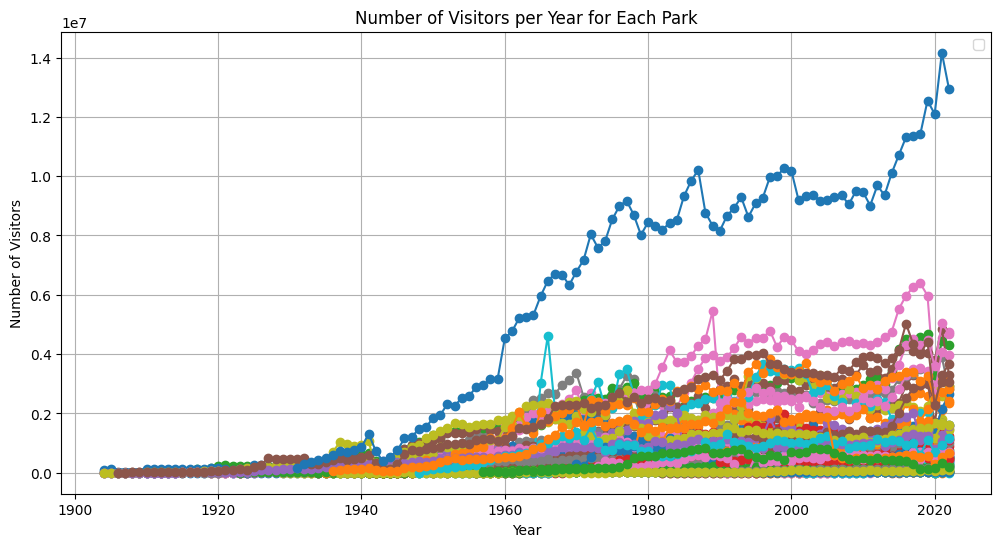

In [78]:
#Annual TRV for each park
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # Adjust the figure size if needed

df = annual_recreational_visits_national_parks_cleaned[annual_recreational_visits_national_parks_cleaned["ParkName"]=="Virgin Islands NP"][["Year", "TRV"]]
df = df.sort_values(by = "Year", ascending = True)

# Loop through each park and plot its time series
for park_name in annual_recreational_visits_national_parks_cleaned["ParkName"].unique():
  df = annual_recreational_visits_national_parks_cleaned[annual_recreational_visits_national_parks_cleaned["ParkName"] == park_name]
  plt.plot(df["Year"], df["TRV"], marker='o', linestyle='-')


# Customize the plot
plt.title('Number of Visitors per Year for Each Park')
plt.xlabel('Year')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [79]:
from bokeh.plotting import figure, show
from bokeh.plotting import output_notebook

output_notebook()

# create a new plot with a title and axis labels
p = figure(title="Number of Visitors per Year for Each Park", x_axis_label="Year", y_axis_label="Number of visitors")

# Loop through each park and plot its time series
for park_name in annual_recreational_visits_national_parks_cleaned["ParkName"].unique():
  df = annual_recreational_visits_national_parks_cleaned[annual_recreational_visits_national_parks_cleaned["ParkName"] == park_name]
  p.line(df["Year"], df["TRV"], legend_label="Temp.", line_width=2)

# show the results
show(p)


In [82]:
#10-Year Rec Visitation by month
import pandas as pd

national_parks_2013_current_rec_visits_by_month = pd.read_csv("/content/np_recommender/data/national_parks_2013_current_rec_visits_by_month.csv")
national_parks_2013_current_rec_visits_by_month

,ParkName,UnitCode,ParkType,Region,State,Year,Month,RecreationVisits,NonRecreationVisits,RecreationHours,...,NonRecreationVisitsTotal,RecreationHoursTotal,NonRecreationHoursTotal,ConcessionerLodgingTotal,ConcessionerCampingTotal,TentCampersTotal,RVCampersTotal,BackcountryTotal,NonRecreationOvernightStaysTotal,MiscellaneousOvernightStaysTotal
0,Acadia NP,ACAD,National Park,Northeast,ME,2012,1,"11,930",600,"78,738",...,"47,100","12,458,831","47,100",0,0,"124,482","26,760","1,316",0,"8,083"
1,Acadia NP,ACAD,National Park,Northeast,ME,2012,2,"12,388",600,"81,758",...,"47,100","12,458,831","47,100",0,0,"124,482","26,760","1,316",0,"8,083"
2,Acadia NP,ACAD,National Park,Northeast,ME,2012,3,"22,684",600,"149,716",...,"47,100","12,458,831","47,100",0,0,"124,482","26,760","1,316",0,"8,083"
3,Acadia NP,ACAD,National Park,Northeast,ME,2012,4,"59,471",600,"344,929",...,"47,100","12,458,831","47,100",0,0,"124,482","26,760","1,316",0,"8,083"
4,Acadia NP,ACAD,National Park,Northeast,ME,2012,5,"157,406","7,500","894,751",...,"47,100","12,458,831","47,100",0,0,"124,482","26,760","1,316",0,"8,083"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311,Zion NP,ZION,National Park,Intermountain,UT,2022,8,"437,134","1,860","2,922,748",...,"21,900","29,929,496","5,475","56,528",0,"133,666","93,947","10,375",0,"30,234"
8312,Zion NP,ZION,National Park,Intermountain,UT,2022,9,"423,654","1,800","2,717,325",...,"21,900","29,929,496","5,475","56,528",0,"133,666","93,947","10,375",0,"30,234"
8313,Zion NP,ZION,National Park,Intermountain,UT,2022,10,"459,697","1,860","2,885,620",...,"21,900","29,929,496","5,475","56,528",0,"133,666","93,947","10,375",0,"30,234"
8314,Zion NP,ZION,National Park,Intermountain,UT,2022,11,"291,044","1,800","1,806,136",...,"21,900","29,929,496","5,475","56,528",0,"133,666","93,947","10,375",0,"30,234"


In [83]:
national_parks_2013_current_rec_visits_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316 entries, 0 to 8315
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   ParkName                          8316 non-null   object
 1   UnitCode                          8316 non-null   object
 2   ParkType                          8316 non-null   object
 3   Region                            8316 non-null   object
 4   State                             8316 non-null   object
 5   Year                              8316 non-null   int64 
 6   Month                             8316 non-null   int64 
 7   RecreationVisits                  8316 non-null   object
 8   NonRecreationVisits               8316 non-null   object
 9   RecreationHours                   8316 non-null   object
 10  NonRecreationHours                8316 non-null   object
 11  ConcessionerLodging               8316 non-null   object
 12  ConcessionerCamping 

In [84]:
park_visitor_statistics = national_parks_2013_current_rec_visits_by_month[["ParkName", "State", "Month", "Year", "RecreationVisits"]]

#SEASONS v/s MONTHS
#Spring - 3, 4, 5
#Summer - 6, 7, 8
#Fall - 9, 10, 11
#Winter - 12, 1, 2

def season_labeller(row):
  if row["Month"] > 2 and row["Month"] <6:
    return "Spring"
  elif row["Month"] > 5 and row["Month"] <9:
    return "Summer"
  elif row["Month"] > 8 and row["Month"] <12:
    return("Fall")
  else:
    return("Winter")

park_visitor_statistics["Season"] = park_visitor_statistics.apply(season_labeller, axis = 1)

<ipython-input-84-e4ea65ea156f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park_visitor_statistics["Season"] = park_visitor_statistics.apply(season_labeller, axis = 1)


In [85]:
#which park has maximum number of visitors in Fall?
fall_parks = park_visitor_statistics[park_visitor_statistics["Season"] == "Fall"]
fall_parks["RecreationVisits"] = fall_parks.loc[:, "RecreationVisits"].str.replace(",", "").astype(float)
fall_parks_grouped = pd.DataFrame(fall_parks[fall_parks["Year"]==2022].groupby("ParkName")["RecreationVisits"].sum())
fall_parks_arranged = fall_parks_grouped.sort_values(by = "RecreationVisits", ascending = False)
fall_parks_arranged

<ipython-input-85-d023b061e45a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_parks["RecreationVisits"] = fall_parks.loc[:, "RecreationVisits"].str.replace(",", "").astype(float)


,RecreationVisits
ParkName,
Great Smoky Mountains NP,3886170.0
Acadia NP,1289613.0
Rocky Mountain NP,1257475.0
Grand Canyon NP,1205420.0
Zion NP,1174395.0
...,...
Kobuk Valley NP,5295.0
Isle Royale NP,3068.0
Lake Clark NP & PRES,2273.0


In [86]:
#get the set of unique national parks
national_parks = park_visitor_statistics["ParkName"].unique()
national_parks_lowercase = [] #initialize an empty array to store the lowercase national park names
for park in national_parks:
 national_parks_lowercase.append(park.lower())

national_parks_lowercase

['acadia np',
 'arches np',
 'badlands np',
 'big bend np',
 'biscayne np',
 'black canyon of the gunnison np',
 'bryce canyon np',
 'canyonlands np',
 'capitol reef np',
 'carlsbad caverns np',
 'channel islands np',
 'congaree np',
 'crater lake np',
 'cuyahoga valley np',
 'death valley np',
 'denali np & pres',
 'dry tortugas np',
 'everglades np',
 'gates of the arctic np & pres',
 'gateway arch np',
 'glacier bay np & pres',
 'glacier np',
 'grand canyon np',
 'grand teton np',
 'great basin np',
 'great sand dunes np & pres',
 'great smoky mountains np',
 'guadalupe mountains np',
 'haleakala np',
 'hawaii volcanoes np',
 'hot springs np',
 'indiana dunes np',
 'isle royale np',
 'joshua tree np',
 'katmai np & pres',
 'kenai fjords np',
 'kings canyon np',
 'kobuk valley np',
 'lake clark np & pres',
 'lassen volcanic np',
 'mammoth cave np',
 'mesa verde np',
 'mount rainier np',
 'national park of american samoa',
 'new river gorge np & pres',
 'north cascades np',
 'olympic 

In [89]:
national_parks_acreage_2022 = pd.read_csv("/content/np_recommender/data/national_parks_acreage.csv")
national_parks_acreage_2022 = national_parks_acreage_2022[["Area Name", "Gross Area Acres"]]

#rename column names
national_parks_acreage_2022 = national_parks_acreage_2022.rename(columns = {"Area Name": "ParkName", "Gross Area Acres": "TotalAcres"})

#typecast "TotalAcres" to float
national_parks_acreage_2022["TotalAcres"] = national_parks_acreage_2022.loc[:,"TotalAcres"].str.replace(",","").astype(float)

#convert "ParkName" to lowercase to join with other tables
national_parks_acreage_2022["ParkName"] = national_parks_acreage_2022.loc[:,"ParkName"].str.lower()

#find the acreage of just the 63 NATIONAL PARKS
national_parks_acreage_2022 = national_parks_acreage_2022[national_parks_acreage_2022["ParkName"].isin(national_parks_lowercase)]

#reset dataframe index
national_parks_acreage_2022 = national_parks_acreage_2022.reset_index()

#convert acres to sqmiles
national_parks_acreage_2022["TotalSqMiles"] = national_parks_acreage_2022["TotalAcres"] * 0.0015625
national_parks_acreage_2022 = national_parks_acreage_2022[["ParkName", "TotalSqMiles"]]

#print results
national_parks_acreage_2022.sort_values(by = "TotalSqMiles", ascending = False)

,ParkName,TotalSqMiles
57,wrangell-st. elias np & pres,13004.916375
17,gates of the arctic np & pres,11756.089766
33,katmai np & pres,5741.452078
14,death valley np,5325.618172
58,yellowstone np,3468.422984
...,...,...
46,pinnacles np,41.696453
30,indiana dunes np,23.982938
53,virgin islands np,23.519266
29,hot springs np,8.678359


In [90]:
#lowercase the "ParkName" attribute in the park visitor statistics dataframe
park_visitor_statistics["ParkName"] = park_visitor_statistics.loc[:,"ParkName"].str.lower()
park_visitor_statistics

#inner join with the park acreage data frame
park_visitor_statistic_w_sqmiles = pd.merge(park_visitor_statistics, national_parks_acreage_2022, left_on = "ParkName", right_on = "ParkName", how = "inner")

#Change "RecreationVisits" from string to float
park_visitor_statistic_w_sqmiles["RecreationVisits"] = park_visitor_statistic_w_sqmiles.loc[:,"RecreationVisits"].str.replace(",", "").astype(float)

#calculate the number of visitors per sqmile per season
park_visitor_statistic_w_sqmiles["VisitorsPerSqMiles"] = park_visitor_statistic_w_sqmiles["RecreationVisits"] / park_visitor_statistic_w_sqmiles["TotalSqMiles"]

park_visitor_statistic_w_sqmiles_2022 = park_visitor_statistic_w_sqmiles[park_visitor_statistic_w_sqmiles["Year"]==2022].sort_values(by = "VisitorsPerSqMiles", ascending = True)

<ipython-input-90-95166a27cd35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park_visitor_statistics["ParkName"] = park_visitor_statistics.loc[:,"ParkName"].str.lower()


In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have a DataFrame, or you can read data from a file, CSV, etc.
# df = pd.read_csv('your_data.csv')

# Specify the column for which you want to create a histogram
column_name = 'your_column_name'
test = fall[fall["RecreationVisits"]<25000]

# Plotting a histogram
plt.hist(fall["RecreationVisits"], bins=100)  # Adjust the number of bins as needed
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title(f'Histogram of {column_name}')
plt.show()

NameError: ignored

In [ ]:
#Experiment
test = park_visitor_statistic_w_sqmiles
test

,ParkName,State,Month,Year,RecreationVisits,Season,TotalSqMiles,VisitorsPerSqMiles
0,acadia np,ME,1,2012,11930.0,Winter,76.674063,155.593686
1,acadia np,ME,2,2012,12388.0,Winter,76.674063,161.567023
2,acadia np,ME,3,2012,22684.0,Spring,76.674063,295.849721
3,acadia np,ME,4,2012,59471.0,Spring,76.674063,775.633872
4,acadia np,ME,5,2012,157406.0,Spring,76.674063,2052.923699
...,...,...,...,...,...,...,...,...
8047,zion np,UT,8,2022,437134.0,Summer,230.066656,1900.031961
8048,zion np,UT,9,2022,423654.0,Fall,230.066656,1841.440246
8049,zion np,UT,10,2022,459697.0,Fall,230.066656,1998.103539
8050,zion np,UT,11,2022,291044.0,Fall,230.066656,1265.042074


<h1>Normalize Distances (Min-Max Scaling)</h1>


In [ ]:
#calculate min-max scaling
